In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/training_dataset.csv",low_memory=False)
df.match_date = df.match_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [2]:
df

,player1_name,player1_atprank,player1_games,player1_wins,player1_loses,player1_indoors_wins,player1_indoors_loses,player1_outdoors_wins,player1_outdoors_loses,player2_name,...,player2_outdoors_wins,player2_outdoors_loses,match_date,match_location,match_tournament,match_court,match_surface,match_odd_player1,match_odd_player2,winner_player1
0,Harrison R.,481,272,117,155,16,17,101,138,Mager G.,...,21,28,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,1.72,2.00,0
1,Korda S.,26,126,75,51,15,9,60,42,Kwon S.W.,...,41,49,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,1.72,2.00,1
2,Paul T.,14,204,111,93,19,13,92,80,Nam J.S.,...,0,3,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,1.12,6.00,1
3,Travaglia S.,1024,81,27,54,5,12,22,42,Kecmanovic M.,...,95,87,2021-01-07,Antalya,Antalya Open,Indoor,Hard,2.62,1.44,1
4,Bellucci T.,915,380,179,201,22,24,157,177,Monteiro T.,...,60,91,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,3.00,1.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7057,Tiafoe F.,10,303,158,145,24,23,134,122,Evans D.,...,106,111,2023-08-05,Washington,Citi Open,Outdoor,Hard,1.29,3.75,0
7058,Griekspoor T.,37,97,47,50,7,14,40,36,Fritz T.,...,179,129,2023-08-06,Washington,Citi Open,Outdoor,Hard,3.50,1.30,1
7059,De Minaur A.,19,272,161,111,30,19,131,92,Tsitsipas S.,...,215,94,2023-08-06,Los Cabos,Los Cabos Open,Outdoor,Hard,3.20,1.36,0
7060,Evans D.,30,251,124,127,18,16,106,111,Dimitrov G.,...,310,212,2023-08-06,Washington,Citi Open,Outdoor,Hard,3.20,1.36,1


In [3]:
df = df.dropna()
df.shape

(7029, 26)

In [6]:
from sklearn.model_selection import train_test_split

X = df[["player1_atprank", "player1_games", "player1_wins", "player1_loses", "player1_indoors_wins","player1_indoors_loses","player1_outdoors_wins","player1_outdoors_loses",
        "player2_atprank", "player2_games", "player2_wins", "player2_loses", "player2_indoors_wins","player2_indoors_loses","player2_outdoors_wins","player2_outdoors_loses",
        "match_date", "match_court", "match_odd_player1", "match_odd_player2"]]
y = df.winner_player1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)# shuffle=False)

In [11]:
from sklearn import preprocessing

X_train_filtered = X_train.drop("match_date",axis=1)
X_test_filtered = X_test.drop("match_date",axis=1)

#normalisation is useless for gradientboostingclassifier

# we encode match_court to binary
X_train_filtered = X_train_filtered.apply(preprocessing.LabelEncoder().fit_transform)
X_test_filtered = X_test_filtered.apply(preprocessing.LabelEncoder().fit_transform)

In [16]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3,max_depth=1, random_state=0)
model = model.fit(X_train_filtered, y_train)

#cross_val_score(dtree, X_test, y_test, cv=10)

y_predict = model.predict(X_test_filtered)

accuracy_score(y_predict, y_test)

0.6756756756756757

In [17]:
# ROI return of investment on all games

print("We bet 1€ on all test matches")
df_roi = X_test.copy()
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")

We bet 1€ on all test matches
money spent: 1406 €
money won: 1389.11 €
TOTAL: -16.8900000000001 €


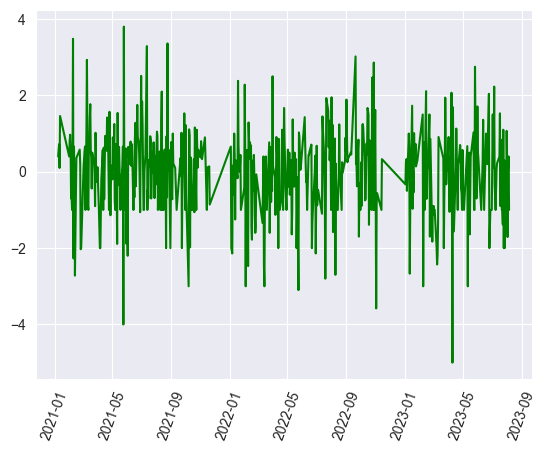

In [18]:
# on all games 
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [19]:
#only games where predict proba is > 0.8

y_predict_proba = model.predict_proba(X_test_filtered)


print("We bet 1€ on all test matches where proba score is > 0.9")
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

df_roi= df_roi.loc[(df_roi["y_predict_proba"]>0.9) | (df_roi["y_predict_proba"]<0.1)]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

We bet 1€ on all test matches where proba score is > 0.9
money spent: 112 €
money won: 120.83 €
TOTAL: 8.83 €
ROI: 107.88 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_34968\3627483195.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


In [20]:
df_roi

,player1_atprank,player1_games,player1_wins,player1_loses,player1_indoors_wins,player1_indoors_loses,player1_outdoors_wins,player1_outdoors_loses,player2_atprank,player2_games,...,player2_indoors_loses,player2_outdoors_wins,player2_outdoors_loses,match_date,match_court,match_odd_player1,match_odd_player2,y_predict_proba,y_predict,y_test
6273,82,437,204,233,17,31,187,202,1,164,...,5,120,29,2023-05-13,Outdoor,17.00,1.03,0.941414,0,0
598,625,11,1,10,0,0,1,10,287,678,...,39,321,270,2021-03-24,Outdoor,6.00,1.12,0.922159,0,1
6034,745,33,16,17,0,1,16,16,54,80,...,6,31,42,2023-04-17,Outdoor,19.00,1.02,0.922000,0,0
3115,4,275,176,99,19,16,157,83,29,64,...,3,27,33,2022-03-12,Outdoor,1.20,4.50,0.083281,1,1
1636,197,395,196,199,16,23,180,176,654,4,...,0,0,4,2021-07-20,Outdoor,1.11,6.50,0.001694,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,2,1223,1017,206,76,40,941,166,69,150,...,14,48,68,2022-01-17,Outdoor,1.05,11.00,0.047299,1,1
497,3,406,289,117,69,27,220,90,150,93,...,19,24,31,2021-03-11,Indoor,1.14,5.50,0.095679,1,1
6166,1,164,130,34,10,5,120,29,55,158,...,18,63,61,2023-04-28,Outdoor,1.04,13.00,0.043317,1,1
4054,10,303,158,145,24,23,134,122,144,91,...,8,29,52,2022-06-29,Outdoor,1.20,4.50,0.094242,1,1


In [ ]:
#indoor / outdoor semble avoir peu d'influence